## Generative Adversarial Network

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Fashon MNIST

In [2]:
fashion_mnist=tf.keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist
X_train, X_test = X_train/255., X_test/255. 

In [3]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

## Vanilla GAN

In [4]:
coding_size = 30

In [5]:
Dense = tf.keras.layers.Dense

In [ ]:
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])

In [7]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])

In [8]:
gan = tf.keras.Sequential([generator, discriminator])

## Both Discriminator and GAN are binary classivier models, so BCE loss will be used
## Generator is not explicitly visible so no loss is required. Its outputs will be implicitly present on the GAN loss.
## In the above Discriminator and GAN are independent models! Discriminator in GAN is not the same as the standalone Discriminator model, which can be trained independently.

In [9]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False # This only plays a role in the compile below
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [10]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [11]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # Discriminator training
            noise = tf.random.normal(shape=[batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Generator training
            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

In [ ]:
train_gan(gan, dataset, batch_size, coding_size, n_epochs=10)

1/1 [==============================] - 0s 46ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

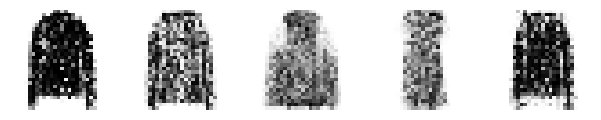

In [14]:
def plot_reconstructions(generator, coding_size=30, n_images=5):
    codings = tf.random.normal(shape=[n_images, coding_size])
    generated_images = np.clip(generator.predict(codings), 0, 255)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(generated_images[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(generator)
plt.show

## Mode collapse mitigation: experience replay and batch similarity score enforcing generator samples variance

## DCGAN

In [16]:
coding_size = 100

In [34]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
])

discriminator =  tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [35]:
gan = tf.keras.Sequential([generator, discriminator])

In [36]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False # This only plays a role in the compile below
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [37]:
batch_size = 32
X_train_dcg = X_train.reshape(-1, 28 ,28, 1) * 2. - 1. # Normalize to tanh() generator output
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcg).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [38]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # Discriminator training
            noise = tf.random.normal(shape=[batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Generator training
            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

In [ ]:
train_gan(gan, dataset, batch_size, coding_size, n_epochs=10)

1/1 [==============================] - 0s 185ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

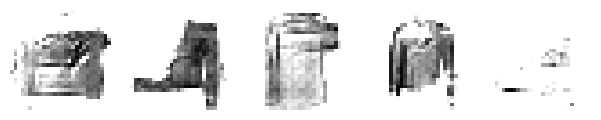

In [40]:
plot_reconstructions(generator, coding_size=100)
plt.show

## Latent arithmetics on GANs: averagad latents of classes can be used as a liner space and the resulting generations will exhibit semantic arithmetics

## Conditional GAN can be obtained by providing additional input with class ID to generator and discriminator 

## Scaling images up is possible with progressively growing GAN layers, with upsamplings added gradually during training with larger and larger resulting output feature maps dimensions (2^n for n layers)

## Stabilizing techniques:
 * Equalized learning rate
 * Pixelwise normalization